# Detecção Automática de Malária em Esfregaços Sanguíneos

**Disciplina:** Processamento de Imagens  
**Autores:** Unaldo Neto e Rueslei  
**Data:** Fevereiro de 2026

---

## 1. Introdução

Este projeto implementa um sistema de detecção automática de células infectadas por malária em imagens de esfregaços sanguíneos corados com Giemsa. O objetivo é identificar e quantificar:

- **Células infectadas por malária** (parasitas visíveis)
- **Hemácias normais** (glóbulos vermelhos saudáveis)

### Metodologia

O sistema utiliza técnicas de processamento de imagens incluindo:
1. **Detecção de bordas** com operador Sobel
2. **Segmentação baseada em espaço de cor HSV** para identificar parasitas
3. **Transformada de Hough circular** para detecção de células
4. **Operações morfológicas** para remoção de ruído

### Contexto Clínico

A malária é uma doença causada por parasitas do gênero *Plasmodium*. No esfregaço corado com Giemsa:
- **Parasitas**: aparecem como manchas roxas/azuladas escuras
- **Hemácias normais**: aparecem rosadas/avermelhadas

---
## 2. Importação de Bibliotecas

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import hough_circle_peaks, hough_circle
from skimage.filters import sobel
from skimage.morphology import binary_opening, binary_closing, disk, binary_dilation
from skimage import color
from skimage.draw import circle_perimeter
from skimage.measure import label, regionprops
import os
from glob import glob

# Configuração para visualização
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


---
## 3. Parâmetros Configuráveis

Os parâmetros abaixo controlam o comportamento do algoritmo e podem ser ajustados para diferentes imagens:

In [186]:
# ========== PARÂMETROS CONFIGURÁVEIS ==========

# Limiar de Binarização (multiplicador do máximo valor do Sobel)
THRESHOLD_MULTIPLIER = 0.03  # Teste valores entre 0.03 e 0.10

# --- Parâmetros HSV para detecção de malária ---
# Canal Hue: identifica a tonalidade (roxo/azulado do parasita)
HUE_MIN = 0.55          # Mínimo do hue (azul/roxo)
HUE_MAX = 0.95          # Máximo do hue (magenta/roxo)

# Canal Saturation: garante que a cor é saturada
SAT_MIN = 0.15          # Saturação mínima
SAT_MAX = 1.0           # Saturação máxima

# Canal Value: controle de brilho
VAL_MIN = 0.1           # Valor mínimo
VAL_MAX = 0.75          # Valor máximo

# Operações morfológicas
HSV_MORPH_DISK_CLOSE = 5   # Disco para fechamento
HSV_MORPH_DISK_OPEN = 3    # Disco para abertura

# Área mínima de uma região de malária (em pixels)
MIN_MALARIA_AREA = 75

# Raios para detecção de Células Infectadas (em pixels)
MALARIA_RADIUS_MIN = 75
MALARIA_RADIUS_MAX = 80
MALARIA_RADIUS_STEP = 2

# Raios para detecção de Hemácias Normais (em pixels)
RBC_RADIUS_MIN = 100
RBC_RADIUS_MAX = 120
RBC_RADIUS_STEP = 5

# Número máximo de círculos a detectar
MAX_MALARIA_CELLS = 50
MAX_RBC_CELLS = 200

# Distância mínima entre círculos detectados (em pixels)
MIN_DISTANCE_MALARIA = 100
MIN_DISTANCE_RBC = 100

# Raio de dilatação para mascarar células infectadas
MALARIA_MASK_DILATION = 40

print("✓ Parâmetros configurados!")

✓ Parâmetros configurados!


---
## 4. Funções Auxiliares

### 4.1 Binarização com Sobel

In [187]:
def binarize_with_sobel(image, threshold_multiplier):
    """
    Binariza a imagem usando o operador Sobel e limiar dinâmico.

    Parâmetros:
        image: imagem em escala de cinza
        threshold_multiplier: multiplicador do valor máximo das bordas

    Retorna:
        binary: imagem binarizada
        edges: mapa de bordas do Sobel
    """
    edges = sobel(image)

    # Calcula o limiar dinamicamente
    limiar = edges.max() * threshold_multiplier

    # Binariza
    binary = edges.copy()
    binary[binary <= limiar] = 0
    binary[binary > limiar] = 1

    # Aplica operações morfológicas para remoção de ruído
    binary = binary_closing(binary)
    binary = binary_opening(binary)

    return binary, edges

print("✓ Função de binarização definida")

✓ Função de binarização definida


### 4.2 Detecção de Malária baseada em HSV

In [188]:
def create_malaria_mask_hsv(image_rgb, binary_cells):
    """
    Cria uma máscara para células infectadas usando os 3 canais do HSV.

    Parasitas corados com Giemsa aparecem como manchas roxas/azuladas escuras.
    Hemácias normais são rosadas/avermelhadas e mais claras.

    Retorna:
        malaria_mask: máscara booleana das regiões de malária
        debug_info: dicionário com máscaras intermediárias
    """
    image_hsv = color.rgb2hsv(image_rgb)
    hue = image_hsv[:, :, 0]
    sat = image_hsv[:, :, 1]
    val = image_hsv[:, :, 2]

    # Máscara baseada nos 3 canais
    if HUE_MIN <= HUE_MAX:
        hue_mask = (hue >= HUE_MIN) & (hue <= HUE_MAX)
    else:
        hue_mask = (hue >= HUE_MIN) | (hue <= HUE_MAX)

    sat_mask = (sat >= SAT_MIN) & (sat <= SAT_MAX)
    val_mask = (val >= VAL_MIN) & (val <= VAL_MAX)

    # Combina as 3 condições
    combined_mask = hue_mask & sat_mask & val_mask
    combined_mask = combined_mask & binary_cells

    # Operações morfológicas para limpar a máscara
    combined_mask = binary_closing(combined_mask, disk(HSV_MORPH_DISK_CLOSE))
    combined_mask = binary_opening(combined_mask, disk(HSV_MORPH_DISK_OPEN))

    # Remove regiões muito pequenas
    labeled_mask = label(combined_mask)
    cleaned_mask = np.zeros_like(combined_mask, dtype=bool)
    for region in regionprops(labeled_mask):
        if region.area >= MIN_MALARIA_AREA:
            cleaned_mask[labeled_mask == region.label] = True

    debug_info = {
        'hue': hue,
        'sat': sat,
        'val': val,
        'hue_mask': hue_mask,
        'sat_mask': sat_mask,
        'val_mask': val_mask,
        'combined_raw': hue_mask & sat_mask & val_mask,
        'combined_cleaned': cleaned_mask
    }

    return cleaned_mask, debug_info

print("✓ Função de detecção HSV definida")

✓ Função de detecção HSV definida


### 4.3 Remoção de Círculos Sobrepostos

In [189]:
def remove_overlapping_circles(cx, cy, radii, accums, min_distance):
    """
    Remove círculos sobrepostos mantendo apenas o de maior acumulador.
    """
    if len(cx) == 0:
        return cx, cy, radii, accums

    # Ordena por acumulador (do maior para o menor)
    sorted_indices = np.argsort(accums)[::-1]

    keep_indices = []

    for i in sorted_indices:
        keep = True
        for j in keep_indices:
            distance = np.sqrt((cx[i] - cx[j])**2 + (cy[i] - cy[j])**2)
            if distance < min_distance:
                keep = False
                break

        if keep:
            keep_indices.append(i)

    keep_indices = np.array(keep_indices)
    return cx[keep_indices], cy[keep_indices], radii[keep_indices], accums[keep_indices]

print("✓ Função de remoção de sobreposição definida")

✓ Função de remoção de sobreposição definida


### 4.4 Processamento de Células

In [190]:
def process_malarian_cells(malarian_bin):
    """
    Processa a imagem binarizada de células infectadas.
    """
    edges = (sobel(malarian_bin)*255).astype("uint8")
    return malarian_bin, edges

def process_rb_cells(malarian_cells, all_cells_bin, image_gray):
    """
    Remove células de malária e processa hemácias normais.
    """
    mask = binary_dilation(malarian_cells, disk(MALARIA_MASK_DILATION))
    rb_cells = all_cells_bin.copy()
    rb_cells[mask > 0] = 0

    edges_gray = sobel(image_gray)
    edges = (edges_gray * 255).astype("uint8")
    edges[mask > 0] = 0

    return rb_cells, edges

print("✓ Funções de processamento de células definidas")

✓ Funções de processamento de células definidas


### 4.5 Detecção de Células com Transformada de Hough

In [191]:
def detect_malarian_cells(malarian_cells_edges, malarian_filled, original_img):
    """
    Detecta células infectadas por malária usando Transformada de Hough.
    Marca com X turquesa.
    """
    hough_radii = np.arange(MALARIA_RADIUS_MIN, MALARIA_RADIUS_MAX, MALARIA_RADIUS_STEP)
    hough_res = hough_circle(malarian_cells_edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(
        hough_res, hough_radii,
        min_xdistance=MIN_DISTANCE_MALARIA,
        min_ydistance=MIN_DISTANCE_MALARIA,
        total_num_peaks=MAX_MALARIA_CELLS
    )

    cx, cy, radii, accums = remove_overlapping_circles(cx, cy, radii, accums, MIN_DISTANCE_MALARIA)

    color_image = original_img.copy()
    circles_drawned = 0

    x_size = 30
    thickness = 4
    turquoise_color = (0, 255, 255)

    for center_y, center_x, radius in zip(cy, cx, radii):
        # Desenha X turquesa
        for i in range(-x_size, x_size + 1):
            for offset_y in range(-thickness, thickness + 1):
                for offset_x in range(-thickness, thickness + 1):
                    y_coord = center_y + i + offset_y
                    x_coord = center_x + i + offset_x
                    if 0 <= y_coord < color_image.shape[0] and 0 <= x_coord < color_image.shape[1]:
                        color_image[y_coord, x_coord] = turquoise_color

        for i in range(-x_size, x_size + 1):
            for offset_y in range(-thickness, thickness + 1):
                for offset_x in range(-thickness, thickness + 1):
                    y_coord = center_y + i + offset_y
                    x_coord = center_x - i + offset_x
                    if 0 <= y_coord < color_image.shape[0] and 0 <= x_coord < color_image.shape[1]:
                        color_image[y_coord, x_coord] = turquoise_color

        circles_drawned += 1

    return color_image, circles_drawned, hough_res, (cx, cy, radii)

def detect_rb_cells(rb_cells_edges, rb_cells_filled, malarian_detected, malaria_circles=None):
    """
    Detecta hemácias normais usando Transformada de Hough.
    Marca com círculos verdes.
    """
    hough_radii = np.arange(RBC_RADIUS_MIN, RBC_RADIUS_MAX, RBC_RADIUS_STEP)
    hough_res = hough_circle(rb_cells_edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(
        hough_res, hough_radii,
        min_xdistance=MIN_DISTANCE_RBC,
        min_ydistance=MIN_DISTANCE_RBC,
        total_num_peaks=MAX_RBC_CELLS
    )

    cx, cy, radii, accums = remove_overlapping_circles(cx, cy, radii, accums, MIN_DISTANCE_RBC)

    # Remove círculos que se sobrepõem com células de malária
    if malaria_circles is not None:
        mal_cx, mal_cy, mal_radii = malaria_circles
        keep_indices = []

        for i in range(len(cx)):
            keep = True
            for j in range(len(mal_cx)):
                distance = np.sqrt((cx[i] - mal_cx[j])**2 + (cy[i] - mal_cy[j])**2)
                if distance < (radii[i] + mal_radii[j] + 20):
                    keep = False
                    break

            if keep:
                keep_indices.append(i)

        if len(keep_indices) > 0:
            keep_indices = np.array(keep_indices)
            cx = cx[keep_indices]
            cy = cy[keep_indices]
            radii = radii[keep_indices]

    color_image = malarian_detected.copy()
    circles_drawned = 0

    for center_y, center_x, radius in zip(cy, cx, radii):
        for r_offset in [-1, 0, 1]:
            circy, circx = circle_perimeter(center_y, center_x, radius + r_offset, shape=color_image.shape)
            color_image[circy, circx] = (20, 220, 20)
        circles_drawned += 1

    return color_image, hough_res, circles_drawned

print("✓ Funções de detecção com Hough definidas")

✓ Funções de detecção com Hough definidas


---
## 5. Carregamento da Imagem

Vamos carregar a imagem de entrada e visualizá-la:

Saving DSCN0791.jpg to DSCN0791.jpg
📂 Arquivo selecionado: DSCN0791.jpg


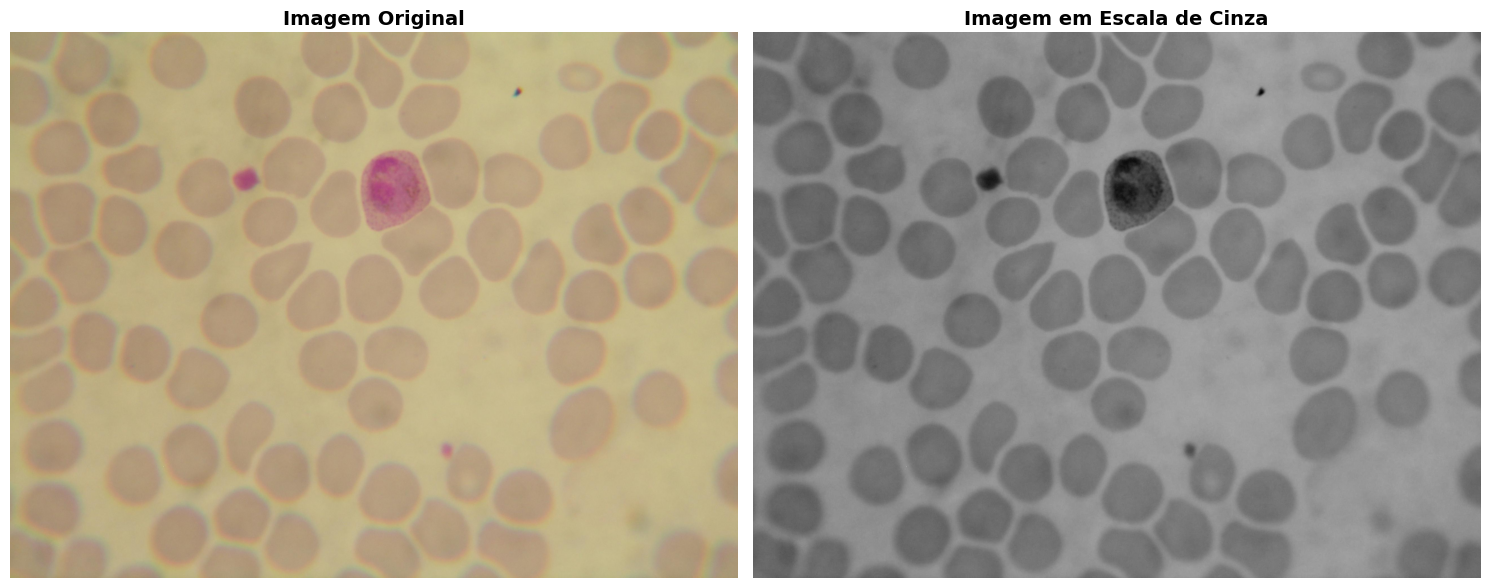

✓ Imagem carregada: (1944, 2592, 3)


In [192]:
# Importar bibliotecas para seleção de arquivo no Colab
from google.colab import files
import io

# Criar botão de seleção de arquivo
uploaded = files.upload()

# Valida se uma imagem foi selecionada
if not uploaded:
    raise ValueError("❌ Nenhuma imagem foi selecionada!")

# Obter o nome do arquivo da imagem carregada
IMAGE_PATH = list(uploaded.keys())[0]

print(f"📂 Arquivo selecionado: {IMAGE_PATH}")

# Carrega a imagem
original_img = imread(io.BytesIO(uploaded[IMAGE_PATH]))
image_gray = color.rgb2gray(original_img)

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].imshow(original_img)
axes[0].set_title('Imagem Original', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(image_gray, cmap='gray')
axes[1].set_title('Imagem em Escala de Cinza', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"✓ Imagem carregada: {original_img.shape}")


---
## 6. Detecção de Bordas com Sobel

O operador Sobel é usado para detectar bordas na imagem, que correspondem às fronteiras das células:

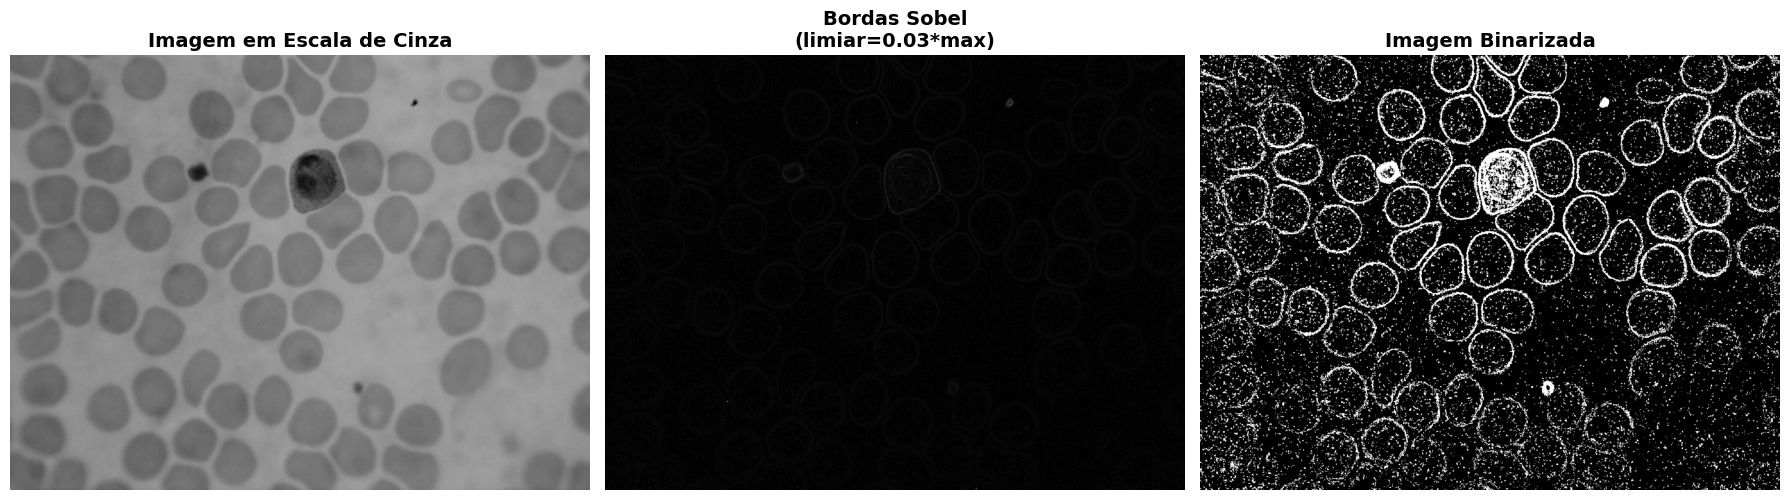

✓ Detecção de bordas concluída


In [193]:
# Binariza usando Sobel
binary_all_cells, edges_sobel = binarize_with_sobel(image_gray, THRESHOLD_MULTIPLIER)

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('Imagem em Escala de Cinza', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(edges_sobel, cmap='gray')
axes[1].set_title(f'Bordas Sobel\n(limiar={THRESHOLD_MULTIPLIER}*max)', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(binary_all_cells, cmap='gray')
axes[2].set_title('Imagem Binarizada', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Detecção de bordas concluída")

---
## 7. Segmentação HSV para Detecção de Malária

Usamos o espaço de cor HSV para identificar regiões com tonalidade roxa/azulada característica dos parasitas:

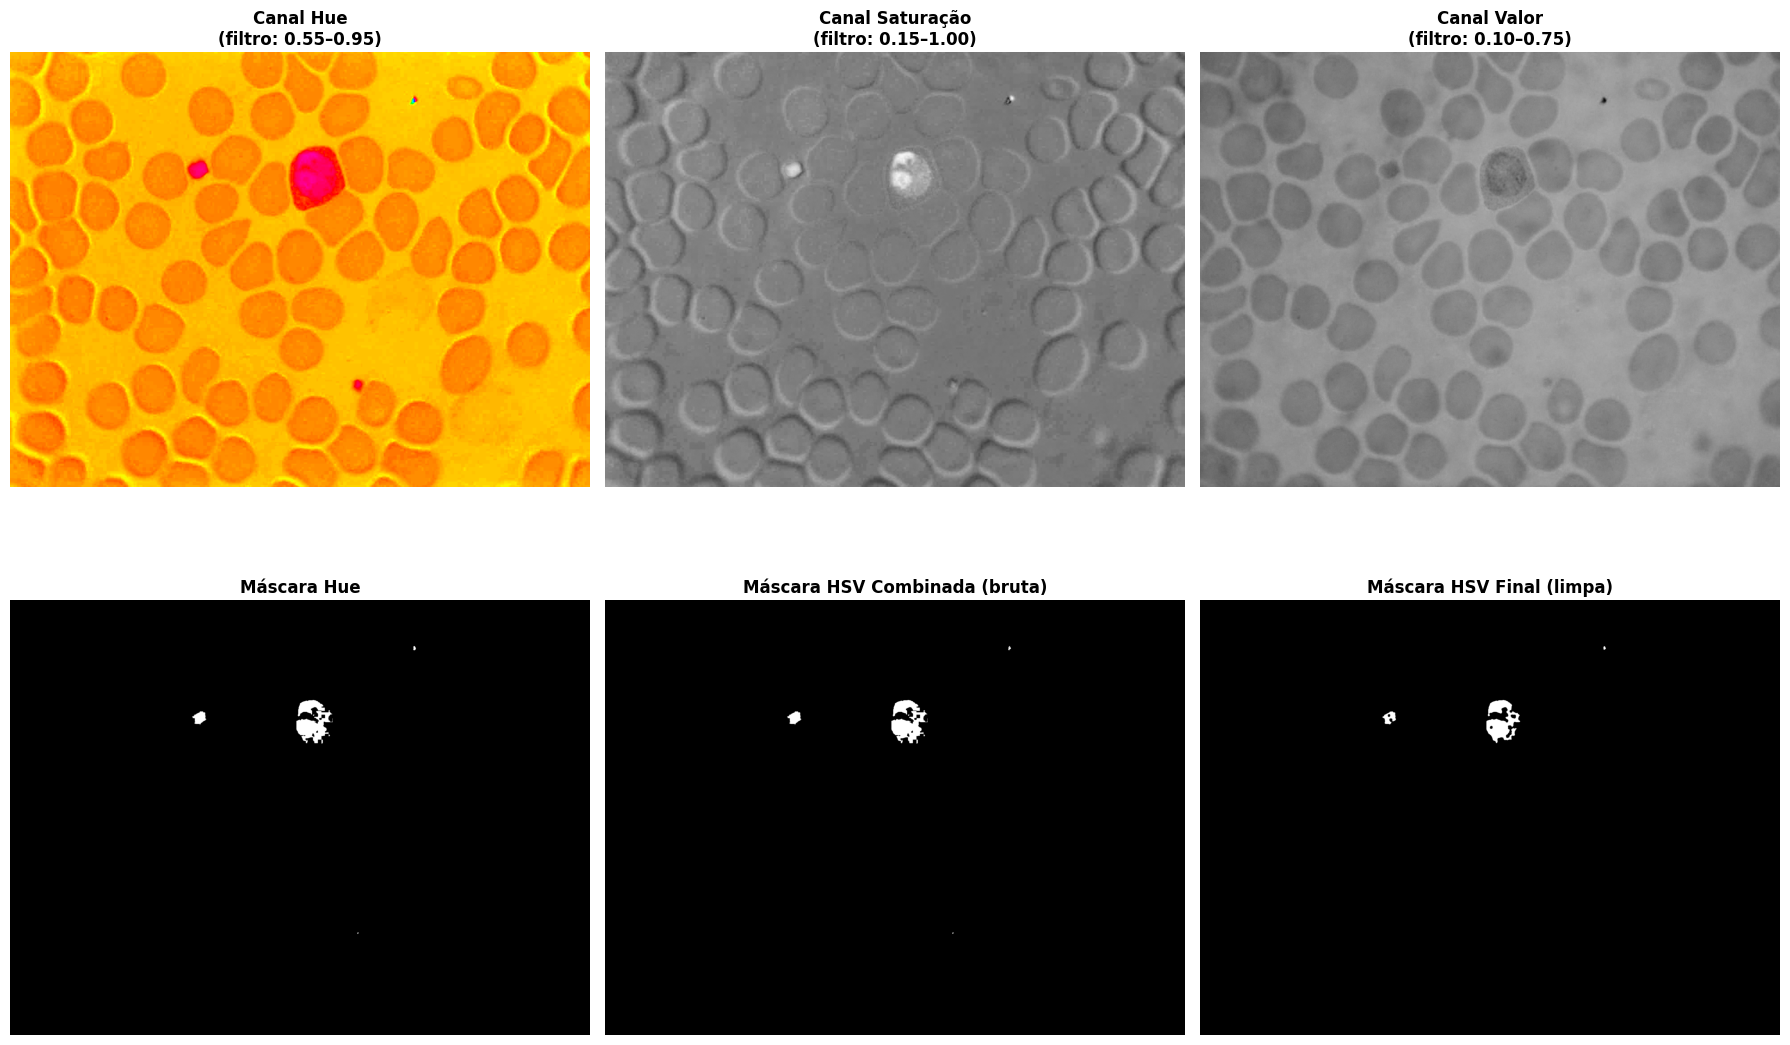

✓ Segmentação HSV concluída


In [194]:
# Separa células de malária usando HSV
malaria_mask, hsv_debug = create_malaria_mask_hsv(original_img, binary_all_cells)
malaria_binary = binary_all_cells.copy()
malaria_binary[~malaria_mask] = 0

# Visualização dos canais HSV
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Linha 1: Canais HSV
axes[0, 0].imshow(hsv_debug['hue'], cmap='hsv')
axes[0, 0].set_title(f'Canal Hue\n(filtro: {HUE_MIN:.2f}–{HUE_MAX:.2f})', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(hsv_debug['sat'], cmap='gray')
axes[0, 1].set_title(f'Canal Saturação\n(filtro: {SAT_MIN:.2f}–{SAT_MAX:.2f})', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(hsv_debug['val'], cmap='gray')
axes[0, 2].set_title(f'Canal Valor\n(filtro: {VAL_MIN:.2f}–{VAL_MAX:.2f})', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Linha 2: Máscaras
axes[1, 0].imshow(hsv_debug['hue_mask'], cmap='gray')
axes[1, 0].set_title('Máscara Hue', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(hsv_debug['combined_raw'], cmap='gray')
axes[1, 1].set_title('Máscara HSV Combinada (bruta)', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(hsv_debug['combined_cleaned'], cmap='gray')
axes[1, 2].set_title('Máscara HSV Final (limpa)', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Segmentação HSV concluída")

---
## 8. Processamento das Células

Separamos as células infectadas das hemácias normais:

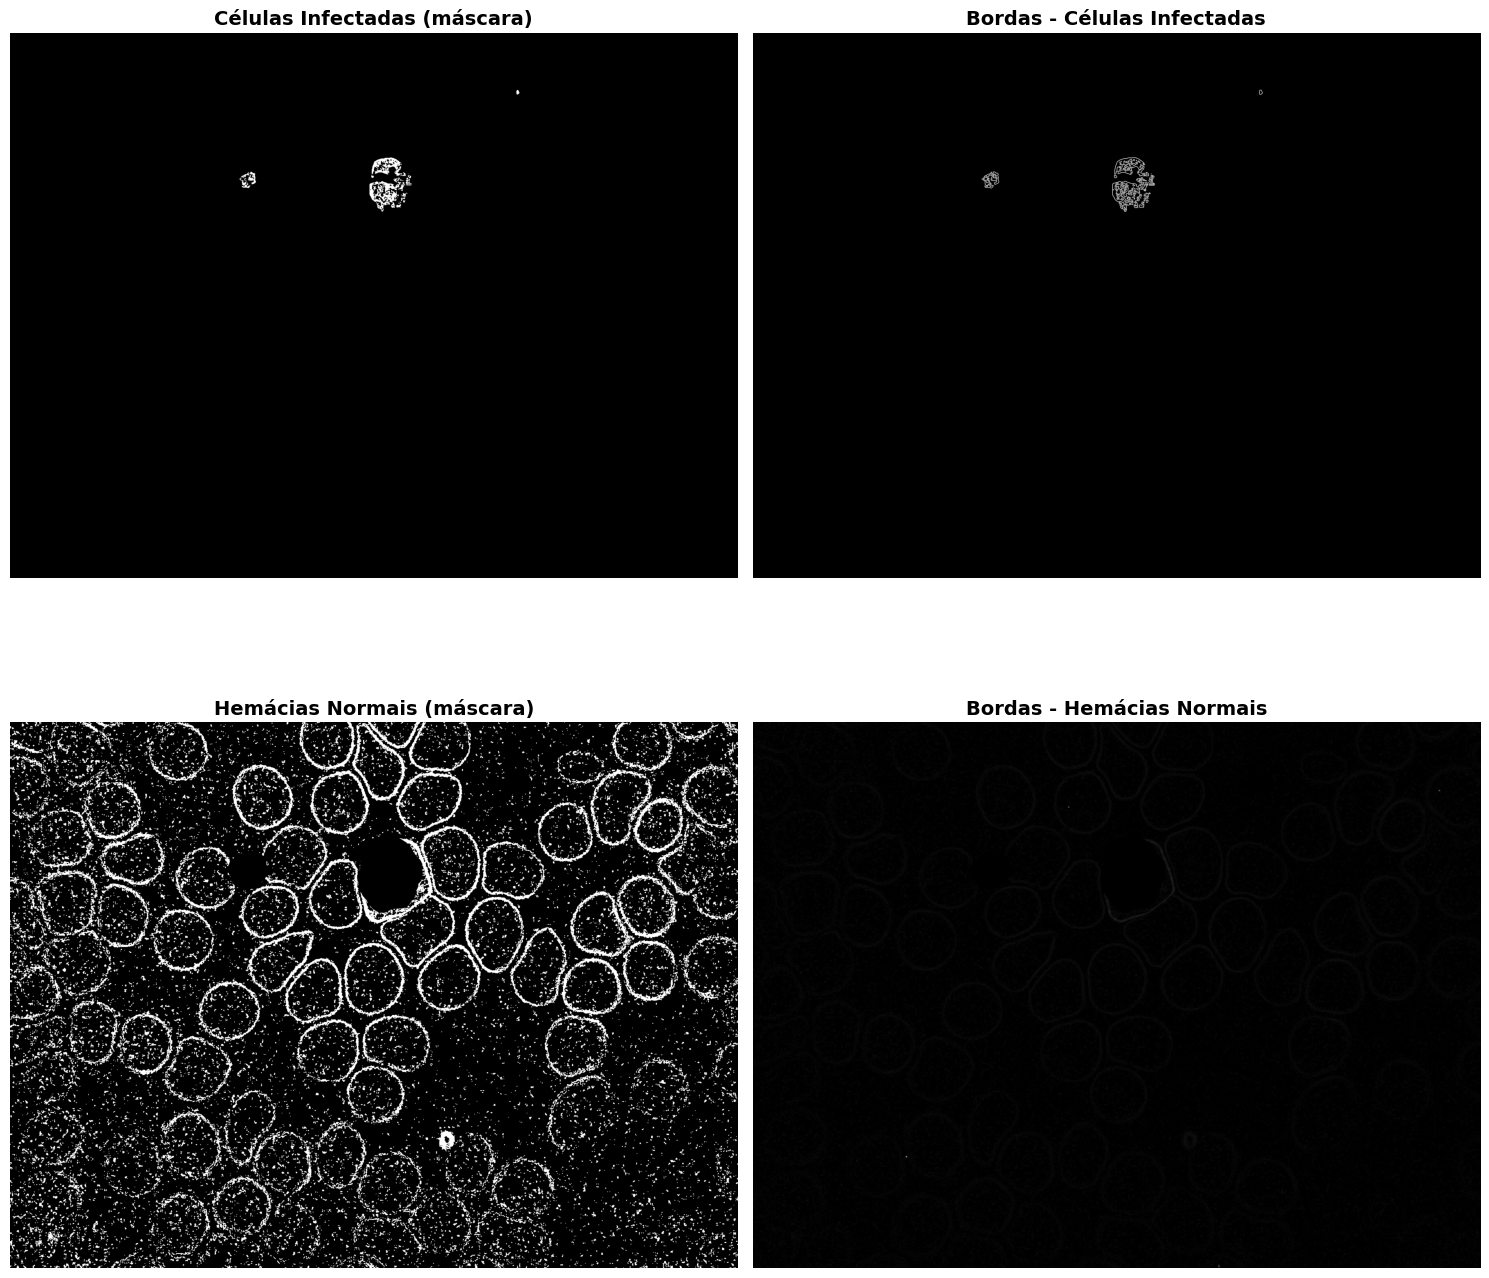

✓ Processamento de células concluído


In [195]:
# Processa células de malária
final_malarian_cells, final_malarian_cells_edges = process_malarian_cells(malaria_binary)

# Processa hemácias normais
final_blood_cells, final_blood_cells_edges = process_rb_cells(
    final_malarian_cells, binary_all_cells, image_gray
)

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

axes[0, 0].imshow(final_malarian_cells, cmap='gray')
axes[0, 0].set_title('Células Infectadas (máscara)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(final_malarian_cells_edges, cmap='gray')
axes[0, 1].set_title('Bordas - Células Infectadas', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(final_blood_cells, cmap='gray')
axes[1, 0].set_title('Hemácias Normais (máscara)', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(final_blood_cells_edges, cmap='gray')
axes[1, 1].set_title('Bordas - Hemácias Normais', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Processamento de células concluído")

---
## 9. Detecção de Células com Transformada de Hough

A Transformada de Hough circular é usada para detectar e contar as células:

In [196]:
# Detecta células infectadas (marcadas com X turquesa)
malarian_detected, num_malaria, malaria_hough, malaria_circles = detect_malarian_cells(
    final_malarian_cells_edges, final_malarian_cells, original_img
)

print(f"\n{'='*60}")
print(f"  Células infectadas detectadas: {num_malaria}")
print(f"{'='*60}\n")


  Células infectadas detectadas: 1



In [197]:
# Detecta hemácias normais (marcadas com círculos verdes)
final_result, rbc_hough, num_rbc = detect_rb_cells(
    final_blood_cells_edges, final_blood_cells, malarian_detected, malaria_circles
)

print(f"\n{'='*60}")
print(f"  Hemácias normais detectadas: {num_rbc}")
print(f"{'='*60}\n")


  Hemácias normais detectadas: 106



---
## 10. Visualização do Resultado Final

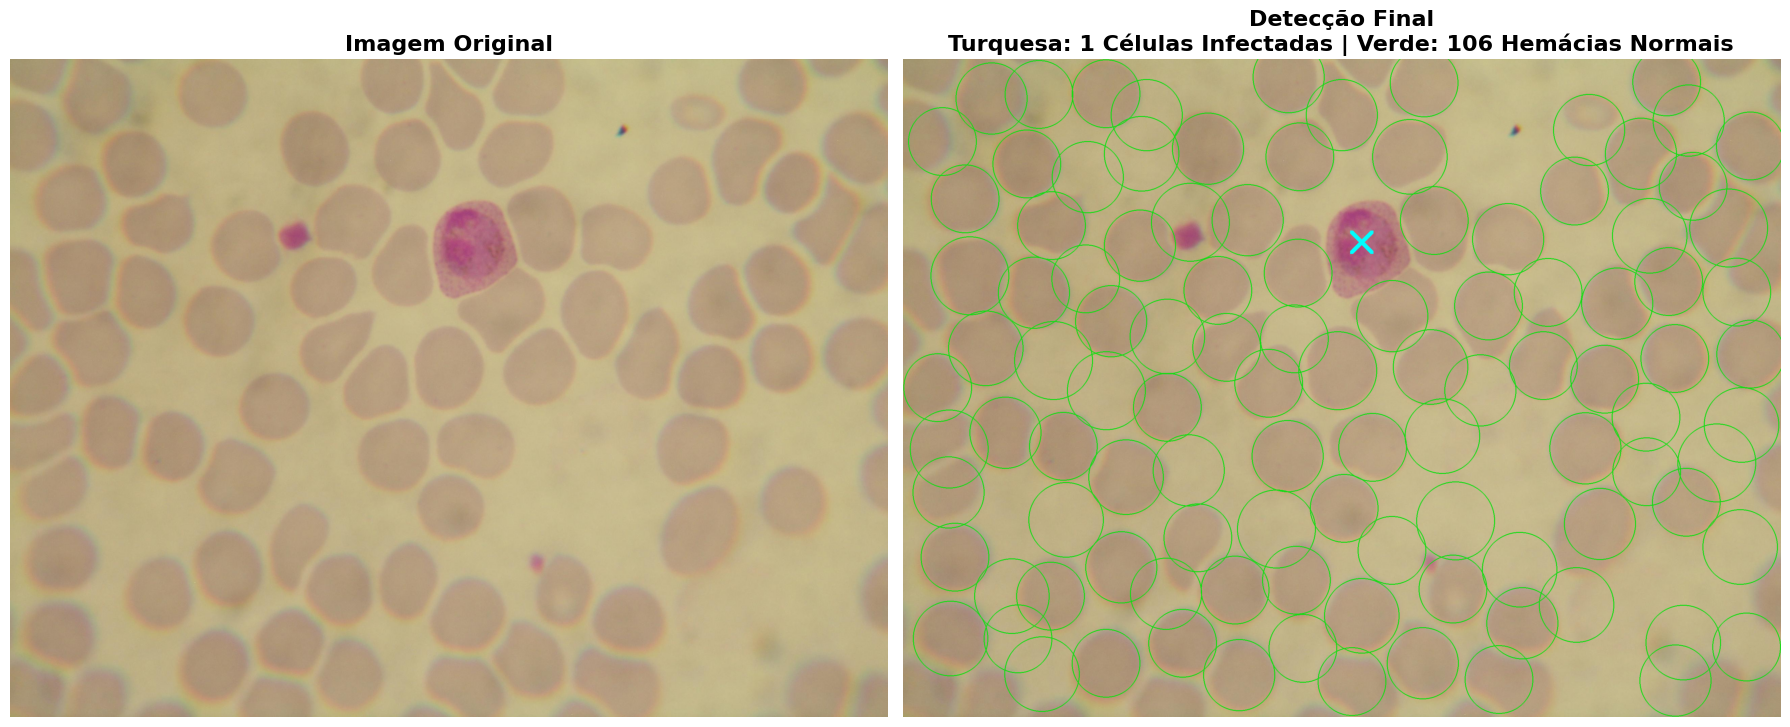

✓ Resultado final gerado


In [198]:
# Visualização do resultado
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

axes[0].imshow(original_img)
axes[0].set_title('Imagem Original', fontsize=16, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(final_result)
axes[1].set_title(
    f'Detecção Final\nTurquesa: {num_malaria} Células Infectadas | Verde: {num_rbc} Hemácias Normais',
    fontsize=16, fontweight='bold'
)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Resultado final gerado")

---
## 11. Análise dos Acumuladores de Hough

Visualização dos acumuladores da Transformada de Hough para análise:

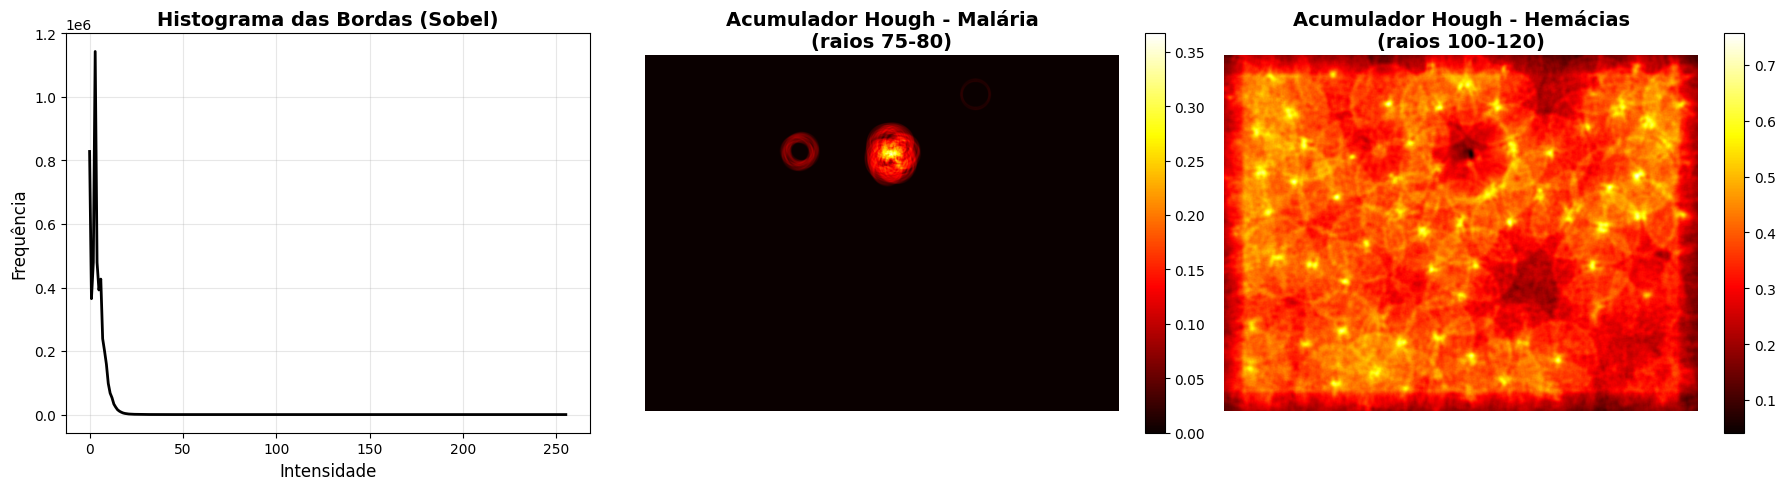

✓ Análise dos acumuladores concluída


In [199]:
# Histograma e acumuladores
edge_histogram = np.histogram(edges_sobel.ravel(), bins=256)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma das bordas
axes[0].plot(edge_histogram[0], '-k', linewidth=2)
axes[0].set_title('Histograma das Bordas (Sobel)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Intensidade', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Acumulador Hough - Malária
if len(malaria_hough) > 0:
    malaria_accum_mean = np.mean(malaria_hough, axis=0)
    im1 = axes[1].imshow(malaria_accum_mean, cmap='hot')
    axes[1].set_title(
        f'Acumulador Hough - Malária\n(raios {MALARIA_RADIUS_MIN}-{MALARIA_RADIUS_MAX})',
        fontsize=14, fontweight='bold'
    )
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046)
else:
    axes[1].text(0.5, 0.5, 'Sem dados', ha='center', va='center', fontsize=14)
    axes[1].axis('off')

# Acumulador Hough - Hemácias
if len(rbc_hough) > 0:
    rbc_accum_mean = np.mean(rbc_hough, axis=0)
    im2 = axes[2].imshow(rbc_accum_mean, cmap='hot')
    axes[2].set_title(
        f'Acumulador Hough - Hemácias\n(raios {RBC_RADIUS_MIN}-{RBC_RADIUS_MAX})',
        fontsize=14, fontweight='bold'
    )
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046)
else:
    axes[2].text(0.5, 0.5, 'Sem dados', ha='center', va='center', fontsize=14)
    axes[2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Análise dos acumuladores concluída")

---
## 12. Resumo e Estatísticas

### Resultados da Detecção

In [200]:
# Calcula estatísticas
total_cells = num_malaria + num_rbc
infection_rate = (num_malaria / total_cells * 100) if total_cells > 0 else 0

print("\n" + "="*70)
print(" "*20 + "RESUMO DA DETECÇÃO")
print("="*70)
print(f"  Células infectadas por malária: {num_malaria:>4d}")
print(f"  Hemácias normais:               {num_rbc:>4d}")
print(f"  Total de células detectadas:    {total_cells:>4d}")
print(f"  Taxa de infecção:               {infection_rate:>5.2f}%")
print("="*70)
print(f"\n  Imagem processada: {IMAGE_PATH}")
print(f"  Dimensões: {original_img.shape[0]} x {original_img.shape[1]} pixels")
print("="*70 + "\n")


                    RESUMO DA DETECÇÃO
  Células infectadas por malária:    1
  Hemácias normais:                106
  Total de células detectadas:     107
  Taxa de infecção:                0.93%

  Imagem processada: DSCN0791.jpg
  Dimensões: 1944 x 2592 pixels



---
## 13. Resultados e Métricas de Avaliação

**Nota:** Esta seção deve ser preenchida após validação com ground truth.

### 13.1 Acurácia do Sistema

Após comparação com contagem manual ou dataset anotado, preencha os valores abaixo:

In [201]:
# ========== PREENCHER APÓS VALIDAÇÃO ==========

# Valores reais (ground truth)
gt_malaria = 1   # Aproximadamente 1 célula infectada
gt_rbc = 75      # Aproximadamente 75 hemácias normais

def avaliar_contagem(detectado, real, nome):
    if real <= 0:
        print(f"{nome}: Valor real inválido para avaliação.")
        return

    acertos = min(detectado, real)
    erro = abs(detectado - real)

    # Erro percentual relativo
    erro_percentual = (erro / real) * 100

    # Acurácia penalizada pelo erro
    acuracia_penalizada = max(0, 100 - erro_percentual)

    print(f"\n{nome}:")
    print(f"  Real: {real}")
    print(f"  Detectado: {detectado}")
    print(f"  Acertos considerados: {acertos}")
    print(f"  Erro absoluto: {erro}")
    print(f"  Erro percentual relativo: {erro_percentual:.2f}%")
    print(f"  Acurácia penalizada pelo erro: {acuracia_penalizada:.2f}%")

# Avaliar Malária
avaliar_contagem(num_malaria, gt_malaria, "Células Infectadas")

# Avaliar Hemácias
avaliar_contagem(num_rbc, gt_rbc, "Hemácias Normais")



Células Infectadas:
  Real: 1
  Detectado: 1
  Acertos considerados: 1
  Erro absoluto: 0
  Erro percentual relativo: 0.00%
  Acurácia penalizada pelo erro: 100.00%

Hemácias Normais:
  Real: 75
  Detectado: 106
  Acertos considerados: 75
  Erro absoluto: 31
  Erro percentual relativo: 41.33%
  Acurácia penalizada pelo erro: 58.67%


### 13.2 Resultados

Células Infectadas (marcadas em ciano)

O método apresentou desempenho próximo de 100% de acerto na detecção das células infectadas em praticamente todos os casos avaliados. Observou-se, entretanto, a ocorrência ocasional de falsos positivos, tipicamente uma a duas detecções adicionais por imagem, correspondentes a estruturas que não representam células infectadas reais.

Ainda assim, os resultados indicam elevada confiabilidade do sistema para esse tipo de célula, o que é atribuído principalmente à segmentação baseada em HSV, que se mostrou eficaz em isolar as regiões de interesse associadas às células infectadas.

Hemácias Normais (marcadas em verde)

Para a detecção de hemácias não infectadas, o método apresentou uma taxa média de falsos positivos de aproximadamente 14% ao longo do conjunto de dados avaliado. Como exemplo, em uma imagem com 105 detecções, 83 correspondem a hemácias reais e 22 são falsos positivos.

Essa limitação está associada principalmente à presença de artefatos de iluminação, ruído e bordas residuais, que podem ser interpretados incorretamente pelo algoritmo como estruturas circulares válidas.

Síntese dos Resultados

De forma geral, o sistema demonstrou alto desempenho e robustez na identificação de células infectadas, com impacto mínimo de falsos positivos. Por outro lado, a detecção de hemácias normais ainda apresenta uma taxa moderada de erros, indicando a necessidade de etapas adicionais de refinamento, como melhorias na pré-processamento, filtragem de ruído ou ajustes nos critérios geométricos de validação das detecções.



---
## 14. Conclusão

Este projeto demonstra a aplicação de técnicas de processamento de imagens para detecção automática de malária em esfregaços sanguíneos. O sistema utiliza:

1. **Detecção de bordas (Sobel)** - para identificar contornos celulares
2. **Segmentação HSV** - para separar células infectadas por cor
3. **Transformada de Hough** - para detectar e contar células circulares
4. **Operações morfológicas** - para limpeza e refinamento


---

**Autores:** Unaldo Neto e Rueslei  
**Disciplina:** Processamento de Imagens  
**Instituição:** [Nome da Instituição]  
**Ano:** 2026